In [ ]:

# ====================================
# Imports
# ====================================
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Confirm versions
print("NumPy version:", np.__version__)
print("TensorFlow version:", tf.__version__)

NumPy version: 1.26.4
TensorFlow version: 2.19.0


Dataset extracted to /content/bone_cancer_extracted

=== Processing 'train' folder ===
 Deleted 0 unmatched rows from CSV
Remaining train images: 7057


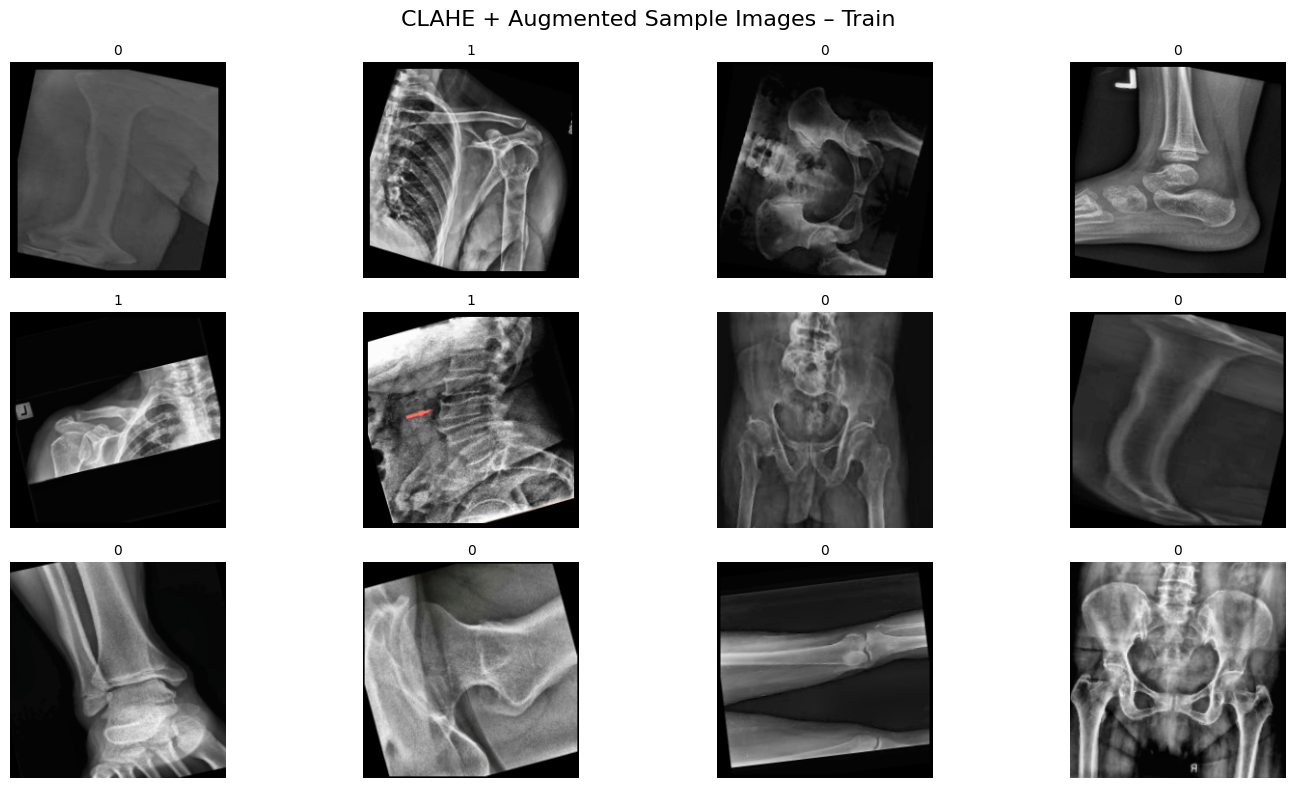


=== Processing 'test' folder ===
 Deleted 0 unmatched rows from CSV
Remaining test images: 872


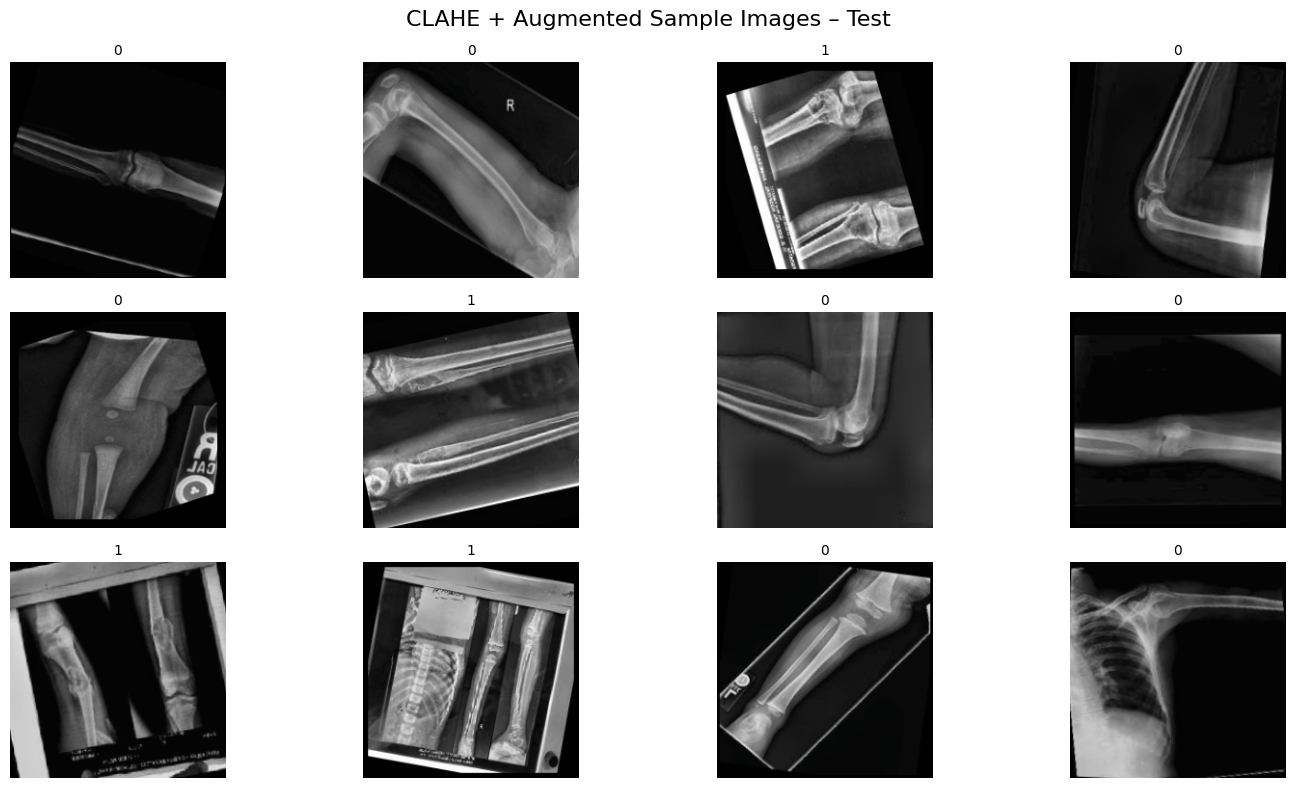


=== Processing 'valid' folder ===
 Deleted 0 unmatched rows from CSV
Remaining valid images: 882


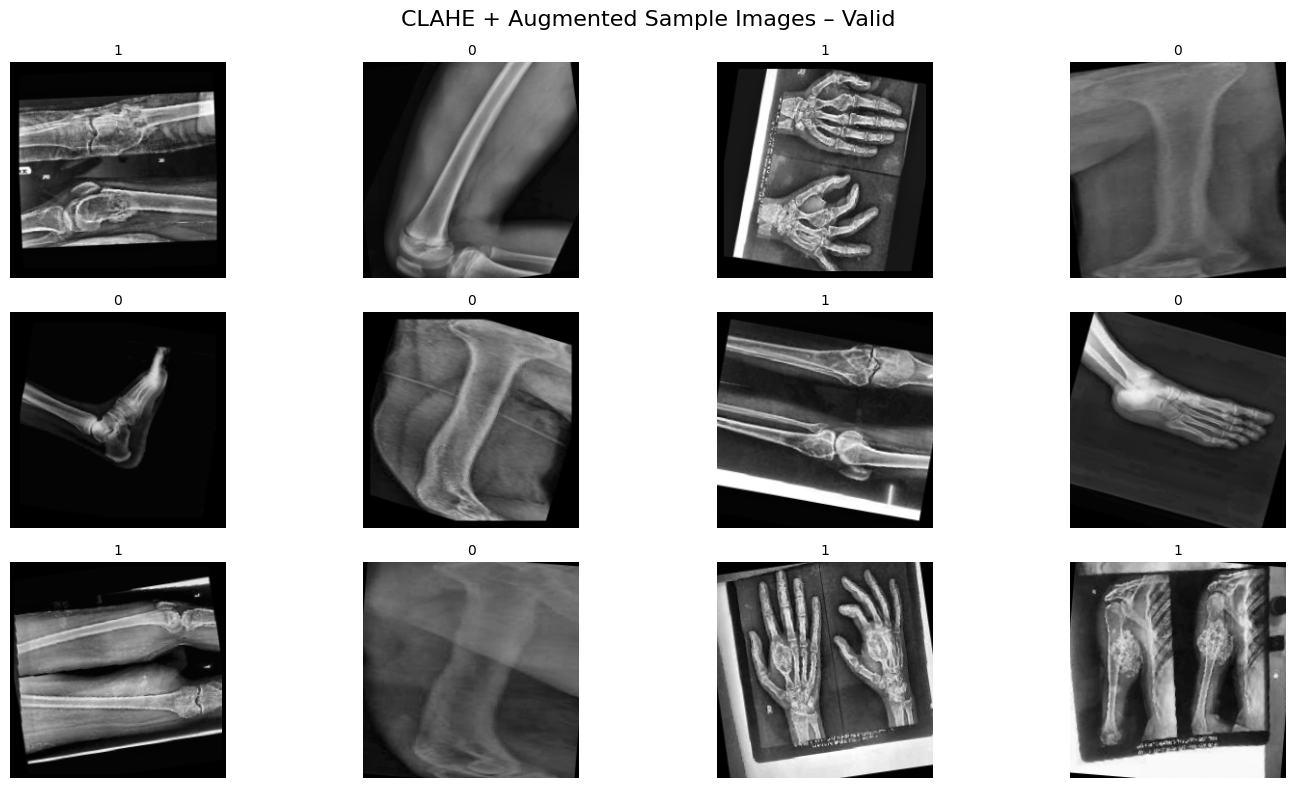

In [ ]:

import zipfile
# === CONFIG ===
zip_path = "/content/bone cancer detection.v1i.multiclass (1).zip"  # Path to uploaded ZIP
extract_path = "/content/bone_cancer_extracted"  # Extraction folder
image_size = (224, 224)
# === STEP 1: Extract ZIP ===
if not os.path.exists(extract_path):
    os.makedirs(extract_path, exist_ok=True)
    if zipfile.is_zipfile(zip_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Dataset extracted to {extract_path}")
    else:
        raise FileNotFoundError(f" {zip_path} is not a valid ZIP file.")
else:
    print(f" Dataset already extracted at {extract_path}")
# === STEP 2: CLAHE Function ===
def apply_clahe(image):
    """Apply CLAHE on the L channel of LAB color space."""
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
# === STEP 3: Cleaning + Augmentation + Display ===
def clean_and_display(folder_name, num_samples=12):
    print(f"\n=== Processing '{folder_name}' folder ===")
    folder_path = os.path.join(extract_path, folder_name)
    csv_path = os.path.join(folder_path, "_classes.csv")
    # Read CSV
    df = pd.read_csv(csv_path)
    # Normalize column names
    if 'filename' in df.columns and 'label' in df.columns:
        filename_col, label_col = 'filename', 'label'
    else:
        filename_col, label_col = df.columns[0], df.columns[1]
    # Clean up entries
    df[filename_col] = df[filename_col].astype(str).str.strip()
    df[label_col] = df[label_col].astype(str).str.strip()
    csv_filenames = set(df[filename_col])
    # Get image files from directory
    folder_files = set(f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png')))

    # 1. Delete images not listed in CSV
    unmatched_images = folder_files - csv_filenames
    for img in unmatched_images:
        os.remove(os.path.join(folder_path, img))
        print(f" Deleted image not in CSV: {img}")
    # 2. Remove CSV rows where image is missing
    unmatched_csv_entries = csv_filenames - folder_files
    original_len = len(df)
    df_cleaned = df[~df[filename_col].isin(unmatched_csv_entries)]
    removed_rows = original_len - len(df_cleaned)
    df_cleaned.to_csv(csv_path, index=False)
    print(f" Deleted {removed_rows} unmatched rows from CSV")
    # 3. Count remaining images
    remaining_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Remaining {folder_name} images: {len(remaining_images)}")
    # 4. Augmentation pipeline
    aug = iaa.Sequential([
        iaa.Resize(image_size),        # Resize to 224x224
        iaa.Fliplr(0.5),               # Horizontal flip
        iaa.Affine(rotate=(-20, 20)),  # Rotation
        iaa.Affine(scale=(0.9, 1.1))   # Zoom
    ])

    # Display sample images
    label_map = dict(zip(df_cleaned[filename_col], df_cleaned[label_col]))
    sample_images = random.sample(remaining_images, min(num_samples, len(remaining_images)))
    plt.figure(figsize=(15, 8))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Apply CLAHE
        img_clahe = apply_clahe(img)
        # Apply augmentation and normalization
        img_aug = aug(image=img_clahe)
        img_aug = img_aug.astype('float32') / 255.0

        label = label_map.get(img_name, "Unknown")
        plt.subplot(3, 4, i + 1)
        plt.imshow(img_aug)
        plt.axis('off')
        plt.title(label, fontsize=10)
    plt.suptitle(f"CLAHE + Augmented Sample Images – {folder_name.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.show()

# === STEP 4: Run for both train and test folders ===
clean_and_display("train")
clean_and_display("test")
clean_and_display("valid")

In [ ]:
#  Organizing images by label

def organize_images_by_label(base_folder):
    csv_path = os.path.join(base_folder, "_classes.csv")
    df = pd.read_csv(csv_path)

    # Detect columns
    filename_col = 'filename' if 'filename' in df.columns else df.columns[0]
    label_col = 'label' if 'label' in df.columns else df.columns[1]

    # Loop through entries
    for _, row in df.iterrows():
        img_name = str(row[filename_col]).strip()
        label = str(row[label_col]).strip()

        src_path = os.path.join(base_folder, img_name)
        dst_folder = os.path.join(base_folder, label)
        dst_path = os.path.join(dst_folder, img_name)

        if os.path.exists(src_path):
            os.makedirs(dst_folder, exist_ok=True)
            shutil.move(src_path, dst_path)

    print(f"Organized images in '{base_folder}' into class subfolders.")

# Run for both folders
organize_images_by_label(os.path.join(extract_path, "train"))
organize_images_by_label(os.path.join(extract_path, "test"))
organize_images_by_label(os.path.join(extract_path, "valid"))

Organized images in '/content/bone_cancer_extracted/train' into class subfolders.
Organized images in '/content/bone_cancer_extracted/test' into class subfolders.
Organized images in '/content/bone_cancer_extracted/valid' into class subfolders.


In [ ]:
def create_limited_training_set(source_folder, dest_folder, max_images=3000):
    records = []

    # Get all images grouped by label
    for class_name in os.listdir(source_folder):
        class_path = os.path.join(source_folder, class_name)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    records.append((fname, class_name))

    df = pd.DataFrame(records, columns=['filename', 'label'])

    # Calculate per-class limit (balanced)
    unique_classes = df['label'].unique()
    per_class_limit = max_images // len(unique_classes)

    # Balanced sampling
    balanced_df = (
        df.groupby('label', group_keys=False)
          .apply(lambda x: x.sample(min(len(x), per_class_limit), random_state=42))
    )

    # Create destination folders & copy images
    os.makedirs(dest_folder, exist_ok=True)
    for _, row in balanced_df.iterrows():
        img_name = row['filename']
        label = row['label']

        src = os.path.join(source_folder, label, img_name)
        dst_class_folder = os.path.join(dest_folder, label)
        dst = os.path.join(dst_class_folder, img_name)

        if os.path.exists(src):
            os.makedirs(dst_class_folder, exist_ok=True)
            shutil.copy2(src, dst)

    # Save new _classes.csv for limited set
    balanced_df.to_csv(os.path.join(dest_folder, "_classes.csv"), index=False)

    print(f"Created balanced limited training set with {len(balanced_df)} images in: {dest_folder}")
    print(f"Images per class: \n{balanced_df['label'].value_counts()}")



Found 7057 images belonging to 2 classes.
Found 882 images belonging to 2 classes.
Found 872 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Training model: Baseline CNN


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7285 - loss: 0.5985 - val_accuracy: 0.8379 - val_loss: 0.3443
Epoch 2/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 87s 393ms/step - accuracy: 0.8537 - loss: 0.3106 - val_accuracy: 0.8685 - val_loss: 0.2802
Epoch 3/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 85s 385ms/step - accuracy: 0.8705 - loss: 0.2766 - val_accuracy: 0.8776 - val_loss: 0.2828
Epoch 4/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 87s 393ms/step - accuracy: 0.8777 - loss: 0.2669 - val_accuracy: 0.8912 - val_loss: 0.2431
Epoch 5/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 88s 397ms/step - accuracy: 0.8781 - loss: 0.2606 - val_accuracy: 0.8821 - val_loss: 0.2672
Epoch 6/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 86s 389ms/step - accuracy: 0.8854 - loss: 0.2363 - val_accuracy: 0.8889 - val_loss: 0.2464
Epoch 7/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 88s 397ms/step - accuracy: 0.8913 - loss: 0.2446 - val_accuracy: 0.8730 - val_loss: 0.2941
Epoch 8/10
221/221 ━━━━━━━━━━━━━━━━━━━━ 86s 390ms/step - accuracy: 0.8981 - loss: 

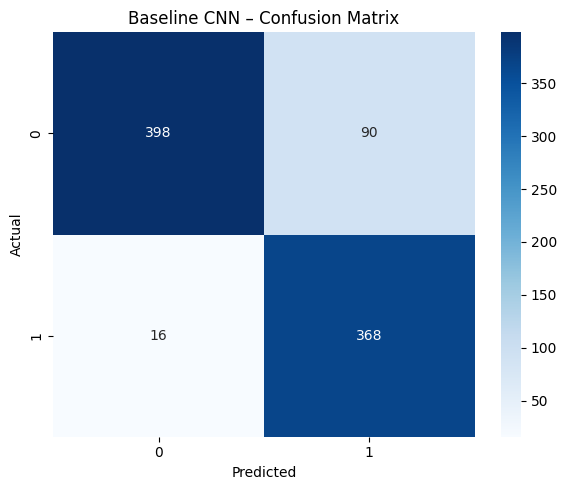


 Evaluation: ResNet50
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       488
           1       0.78      0.79      0.79       384

    accuracy                           0.81       872
   macro avg       0.81      0.81      0.81       872
weighted avg       0.81      0.81      0.81       872



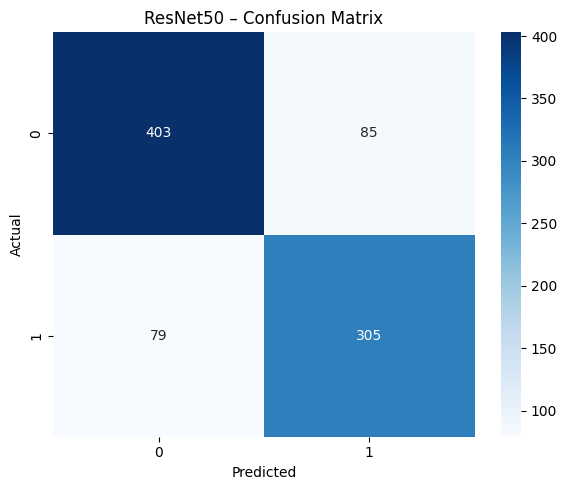


 Evaluation: EfficientNetB0
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 349ms/step
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       488
           1       0.00      0.00      0.00       384

    accuracy                           0.56       872
   macro avg       0.28      0.50      0.36       872
weighted avg       0.31      0.56      0.40       872



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


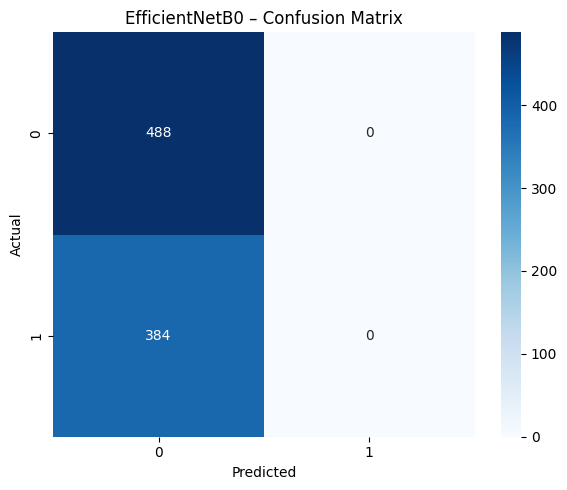

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
from sklearn.metrics import classification_report, confusion_matrix

# === CONFIGURATION ===
image_size = (224, 224)
batch_size = 32
epochs = 10
extract_path = "/content/bone_cancer_extracted"  # adjust if needed
train_dir = os.path.join(extract_path, "train")
valid_dir = os.path.join(extract_path, "valid")
test_dir  = os.path.join(extract_path, "test")

# === DETECT CLASS MODE ===
num_classes = len([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if num_classes == 2:
    class_mode = 'binary'
    final_activation = 'sigmoid'
    loss_fn = 'binary_crossentropy'
else:
    class_mode = 'categorical'
    final_activation = 'softmax'
    loss_fn = 'categorical_crossentropy'

# === DATA GENERATORS ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode
)

val_gen = val_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=class_mode,
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())

# === BASELINE CNN MODEL ===
def create_baseline_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes if class_mode == 'categorical' else 1, activation=final_activation)
    ])
    return model

# === TRANSFER LEARNING WRAPPER ===
def create_transfer_model(base_model, name):
    base_model.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes if class_mode == 'categorical' else 1, activation=final_activation)(x)
    return models.Model(inputs=base_model.input, outputs=output, name=name)

# === TRAINING FUNCTION ===
def compile_and_train(model, name):
    print(f"\n Training model: {name}")
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)
    return model, history

# === EVALUATION FUNCTION ===
def evaluate_model(model, name):
    print(f"\n Evaluation: {name}")
    preds = model.predict(test_gen)
    if class_mode == 'binary':
        y_pred = (preds > 0.5).astype(int).flatten()
    else:
        y_pred = preds.argmax(axis=1)
    y_true = test_gen.classes

    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{name} – Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# === TRAIN MODELS ===
baseline_model, _ = compile_and_train(create_baseline_cnn(), "Baseline CNN")

resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
resnet_model, _ = compile_and_train(create_transfer_model(resnet_base, "ResNet50"), "ResNet50")

effnet_base = applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
effnet_model, _ = compile_and_train(create_transfer_model(effnet_base, "EfficientNetB0"), "EfficientNetB0")

# === EVALUATE MODELS ===
evaluate_model(baseline_model, "Baseline CNN")
evaluate_model(resnet_model, "ResNet50")
evaluate_model(effnet_model, "EfficientNetB0")


In [ ]:
import os
print(os.listdir(train_dir))


['0', '_classes.csv', '1']


In [ ]:
test_class_dir = os.path.join(extract_path, "test", "0")  # or "1"
print("Available images:")
print(os.listdir(test_class_dir))

Available images:
['image-no443-normal-_png.rf.b267b9f47e7852ad31fc4f32b5e2c54b.jpg', 'download-12-_f_png.rf.8bba66e40c4aff793a1e80ff99040767.jpg', 'IMG0000428_jpg.rf.f839f00d17c4dbd26e28061e94c53353.jpg', 'IMG0000618_jpg.rf.1736d9c953c2b33213bdef03ee27adac.jpg', 'Picture11_jpg.rf.b06f4219cf7bbbad93d125c457cd3e9a.jpg', 'Normal-paediatric-shoulder17_png.rf.246f734ab844f4c48a59fabea610fb37.jpg', 'IMG0000291_jpg.rf.77179a2d4673e1ea9d6f56af7de59b73.jpg', 'IMG0000786_jpg.rf.856a6d43839bf21390cd935e1a285467.jpg', 'IMG0000876_jpg.rf.b3e706c871775914e9eadd714f68f2f7.jpg', 'image-no58-normal-_png.rf.5171e5b6c63bbb0123ed6a4c89cd42b2.jpg', 'IMG0000660_jpg.rf.8ad55cf2aa65ba79f2001e9dcff1189c.jpg', 'image-no240-normal-_png.rf.0d532819a9a435478395dbfe8a5465d3.jpg', 'IMG0000509_jpg.rf.81492c92f5eacd5a6c2d60120a8b1c31.jpg', 'image-no466-normal-_png.rf.1d71c2a763417d1aa2e24b4e4bffce58.jpg', '-6-_jpg.rf.4b9c84a8ca6f3e58134c8a1f67b796c0.jpg', 'ankle_9_2_png.rf.5510d052841ab63569c6ac2f1b2ffabc.jpg', 'tf_2

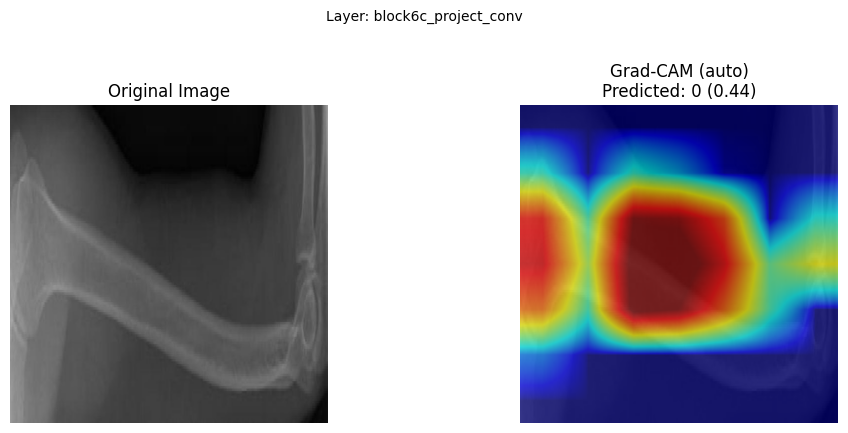

In [ ]:
# ======================= Auto Grad-CAM (+ Grad-CAM++) =======================
import os, cv2, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D

# --- choose the model you want to visualize ---
MODEL_CHOICE = "effnet"   # "effnet" | "resnet" | "baseline"
model_to_use = {
    "effnet": effnet_model,
    "resnet": resnet_model,
    "baseline": baseline_model,
}[MODEL_CHOICE]

# --- pick one test image ---
sample_path = None
for f in os.listdir(test_class_dir):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
        sample_path = os.path.join(test_class_dir, f)
        break
assert sample_path, "No test image found in test_class_dir."

# ---------------- helpers ----------------
def load_image(path, target_size=image_size):
    bgr = cv2.imread(path); assert bgr is not None, f"Can't read {path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb_rs = cv2.resize(rgb, target_size, interpolation=cv2.INTER_AREA)
    x = rgb_rs.astype("float32") / 255.0  # same as your generators
    return rgb, np.expand_dims(x, 0)

def list_conv_layers(model):
    """Return conv-like layers (deepest last) with spatial sizes."""
    convlike = (Conv2D, DepthwiseConv2D, SeparableConv2D)
    out = []
    for lyr in model.layers:
        try:
            s = lyr.output.shape
            if len(s) == 4 and (isinstance(lyr, convlike) or "conv" in lyr.name.lower()):
                H = int(s[1]) if s[1] is not None else None
                W = int(s[2]) if s[2] is not None else None
                out.append((lyr.name, H, W))
        except Exception:
            pass
    return out[::-1]  # deepest last

def forward_title_bits(model, x):
    """Get predicted label/prob for title."""
    p = model.predict(x, verbose=0)
    if class_mode == "binary":
        prob1 = float(p[0,0])
        pred_idx = int(prob1 >= 0.5)
        pred_label = class_names[pred_idx] if len(class_names)==2 else str(pred_idx)
        return pred_label, prob1
    else:
        idx = int(np.argmax(p[0]))
        return class_names[idx], float(p[0, idx])

def gradcam(model, layer_name, x):
    """Standard Grad-CAM (safe)."""
    conv = model.get_layer(layer_name)
    gm = Model([model.input], [conv.output, model.output])
    with tf.GradientTape() as tape:
        conv_out, preds = gm([x], training=False)
        tape.watch(conv_out)  # ensure grads can be taken
        if class_mode == "binary":
            loss = preds[:, 0]
        else:
            idx = tf.argmax(preds[0])
            loss = preds[:, idx]
    grads = tape.gradient(loss, conv_out)
    if grads is None:
        return None
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(weights * conv_out[0], axis=-1)
    cam = tf.nn.relu(cam).numpy()
    return cam

def gradcam_plus_plus(model, layer_name, x):
    """Grad-CAM++ (safe, guards against None)."""
    conv = model.get_layer(layer_name)
    gm = Model([model.input], [conv.output, model.output])
    with tf.GradientTape(persistent=True) as tape:
        conv_out, preds = gm([x], training=False)
        tape.watch(conv_out)
        if class_mode == "binary":
            y_c = preds[:, 0]
        else:
            c = tf.argmax(preds[0])
            y_c = preds[:, c]

    g1 = tape.gradient(y_c, conv_out)
    if g1 is None:
        del tape
        return None
    g2 = tape.gradient(tf.reduce_sum(g1), conv_out)
    if g2 is None:
        del tape
        return None
    g3 = tape.gradient(tf.reduce_sum(g2), conv_out)
    del tape
    if g3 is None:
        return None

    A  = conv_out[0]    # (H,W,C)
    g1 = g1[0]; g2 = g2[0]; g3 = g3[0]

    numerator   = g2
    denominator = 2.0 * g2 + tf.reduce_sum(A * g3, axis=(0,1), keepdims=True)
    denominator = tf.where(tf.equal(denominator, 0.0), tf.ones_like(denominator), denominator)
    alpha = numerator / denominator

    weights = tf.reduce_sum(tf.nn.relu(g1) * alpha, axis=(0,1))  # (C,)
    cam = tf.reduce_sum(tf.nn.relu(weights) * A, axis=-1)
    cam = tf.nn.relu(cam).numpy()
    return cam

def score_map(cam):
    """Higher = more vivid. Percentile normalize first."""
    if cam is None or not np.isfinite(cam).any():
        return -1.0
    cam = cam / (np.percentile(cam, 99) + 1e-8)
    cam = np.clip(cam, 0, 1)
    return float(cam.std())

# --------------- run ---------------
orig_rgb, x = load_image(sample_path)
pred_label, pred_prob = forward_title_bits(model_to_use, x)

# candidate conv layers: prefer non-tiny maps (>=7x7), test deeper first
layers = list_conv_layers(model_to_use)
candidates = [(n,h,w) for (n,h,w) in layers if (h and w and min(h,w) >= 7)]
candidates = candidates[::-1]  # deeper first among filtered
best_cam, best_layer, best_score = None, None, -1.0
for (name, Hs, Ws) in candidates:
    cam1 = gradcam(model_to_use, name, x)
    s1 = score_map(cam1)
    cam2 = gradcam_plus_plus(model_to_use, name, x)
    s2 = score_map(cam2) if cam2 is not None else -1.0

    chosen, score = (cam1, s1) if s1 >= s2 else (cam2, s2)
    if score > best_score:
        best_cam, best_layer, best_score = chosen, name, score
# last resort: if nothing decent, try a small known list for each backbone
if best_cam is None:
    fallback = []
    if MODEL_CHOICE == "effnet":
        fallback = ["block5c_project_conv","block6d_project_conv","block7a_project_conv","top_conv"]
    elif MODEL_CHOICE == "resnet":
        fallback = ["conv5_block2_out","conv5_block3_out"]
    else:  # baseline
        # try to guess last conv name
        for ln, Hs, Ws in layers[::-1]:
            if "conv" in ln.lower():
                fallback.append(ln)
                break
    for name in fallback:
        cam_try = gradcam(model_to_use, name, x)
        if cam_try is not None:
            best_cam, best_layer = cam_try, name
            break

if best_cam is None:
    raise RuntimeError("Could not compute a usable Grad-CAM. Check that the model has conv layers.")
# -------- normalize strongly + overlay (vivid) --------
H, W = orig_rgb.shape[:2]
cam = cv2.resize(best_cam, (W, H))
scale = np.percentile(cam, 95) or (np.max(cam) + 1e-8)
cam = np.clip(cam / (scale + 1e-8), 0, 1) ** 0.6

heatmap_color = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
overlay = np.clip(0.65*heatmap_color + 0.35*orig_rgb, 0, 255).astype(np.uint8)

# ---------------- figure ----------------
plt.figure(figsize=(11,4.2))
plt.suptitle(f"Layer: {best_layer}", y=1.02, fontsize=10)
plt.subplot(1,2,1); plt.imshow(orig_rgb); plt.axis("off"); plt.title("Original Image")
plt.subplot(1,2,2); plt.imshow(overlay); plt.axis("off")
plt.title(f"Grad-CAM (auto)\nPredicted: {pred_label} ({pred_prob:.2f})")
plt.tight_layout(); plt.show()

